In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Nº máximo de remolcadores
MAXREMOLC = 10
# Nº máximo de muelles
MAXMUELLES = 25
# Tiempo máximo de simulación
T = 7 * 24 * 60 # 7 days
REMOLC_MU_VACIO = 2
REMOLC_SIGMA_VACIO = 1
#CAMBIAR VALORES ######
REMOLC_MU_FULL = 10.007615178514001
REMOLC_SIGMA_FULL = 3.0373964893054275
#######
PUERTO_DESCARGA_FREEDOM_DEGREE = 2

In [21]:
def poisson_rate(hour):
    """
    Esta función devuelve la tasa de llegada (ratio de Poisson) para un
    momento dado del día,
    basándose en intervalos de tiempo específicos y sus correspondientes
    tasas de llegada.
    """
    hour_in_day = (hour / 60.0) % 24.0
    if 0.0 <= hour_in_day < 5.0:
        return 2.0 / 5.0 * hour_in_day + 5.0
    elif 5.0 <= hour_in_day < 8.0:
        return -1.0 / 3.0 * hour_in_day + 26.0 / 3.0
    elif 8.0 <= hour_in_day < 15.0:
        return 3.0 / 7.0 * hour_in_day + 18.0 / 7.0
    elif 15.0 <= hour_in_day < 17.0:
        return -3.0 / 2.0 * hour_in_day + 63.0 / 2.0
    elif 17.0 <= hour_in_day < 24.0:
        return -1.0 / 7.0 * hour_in_day + 59.0 / 7.0
    else:
        return 0.0

In [22]:
class Eventos():
    BARCO_LLEGA_PUERTO = 0
    REMOLC_BARCO_TO_MUELLE = 1
    BARCO_DESCARGA_MUELLE = 2
    REMOLC_BARCO_TO_PUERTO = 3
    REMOLC_VACIO_TO_PUERTO = 4
    REMOLC_VACIO_TO_MUELLE = 5
    
class List_Events():
    L = []
    def __init__( self ):
        self.L = []
        
    def add(self, tipo_evento, tiempo, ID=None):
        self.L.append((tipo_evento, tiempo, ID))
        self.L = sorted(self.L, key=lambda x:x[1])
    
    def pop(self):
        tipo_evento, tiempo, ID = self.L[0]
        self.L = self.L[1:]
        return tipo_evento, tiempo, ID
    
class List_Barcos():
    def __init__(self):
        self.L = []
        
    def add(self,time):
        barco = {"id": len(self.L),
                 "llegada_al_sistema":time,
                 "llegada_muelle":-1,
                 }
        self.L.append(barco)
        return self.L[-1]
    
    def get(self,id):
        return self.L[id]
    
class List_Remolcadores():
    L = []
    def __init__(self):
        self.max_remolc = MAXREMOLC
        self.L = [{"id":i, "posición":"at_port", "carry":None} for i in range(0,self.max_remolc)]
    
    def get_remolc_by_index(self, index):
        return self.L[index]
    
    def get_remolc_by_position(self, posicion):
        return list(filter(lambda x:x["posición"] == posicion, self.L))
    
class List_Muelles():
    L = []
    def __init__(self):
        self.max_muelles = MAXMUELLES
        self.L = [{"id":i, "barco_descargando": None} for i in range(0,self.max_muelles)]
        
    def get_muelles_vacios(self):
        return list(filter(lambda x:x["barco_descargando"] is None, self.L))
    
    def get_muelles_by_barco(self, id_barco):
        for muelle in self.L:
            if muelle["barco_descargando"] == id_barco:
                return muelle
        return None

In [23]:
class Simulation():
    def __init__(self):
        self.remolc_mu_empty = REMOLC_MU_VACIO # Parametro mu para los desplazamientos de los remolcadores cuando van de vacio.
        self.remolc_sigma_empty = REMOLC_SIGMA_VACIO # Parametro sigma para los desplazamientos de los remolcadores cuando van de vacio.
        self.remolc_mu_full = REMOLC_MU_FULL # Parametro mu para los desplazamientos de los remolcadores cuando llevan un petrolero.
        self.remolc_sigma_full = REMOLC_SIGMA_FULL # Parametro sigma para los desplazamientos de los remolcadores cuando llevan un petrolero.
        self.puerto_descarga_freedom_degree = PUERTO_DESCARGA_FREEDOM_DEGREE # Grados de libertad para el tiempo de descarga de los petroleros
        self.time = 0.0
        self.tiempo_max = T
        
        self.tiempo_media_barco_muelle = 0.0 # Tiempo medio que tarda un barco para llegar al muelle
        self.tiempo_maximo_barco_muelle = 0.0 # Tiempo maximo que tarda un barco para llegar al muelle
        self.media_barcos_muelle = 0.0 # Numero medio de barcos en los muelles
        self.media_barcos_esperando_entrada = 0.0 # Numero medio de barcos esperando en la entrada
        self.maximo_barcos_esperando_entrada = 0 # Numero maximo de barcos esperando en la entrada
        
        self.lista_eventos = List_Events()
        self.lista_barcos = List_Barcos()
        self.lista_remolc = List_Remolcadores()
        self.lista_muelles = List_Muelles()
        
        self.barcos_entrada_sistema = [] #Cola de la entrada del puerta
        self.barcos_fin_descarga = [] #Cola de petroleros que han terminado de descargar
        self.barcos_salida_sistema = [] #Petroleros que han abandonado el sistema
        
    def simulate(self):
        #Cambiar a Poisson
        value = 60 * random.expovariate(poisson_rate(self.time))
        if value > self.tiempo_max:
            return -1
        else:
            self.lista_eventos.add(Eventos.BARCO_LLEGA_PUERTO ,self.time + value)
            while len(self.lista_eventos.L) > 0:
                evento, tiempo_evento, ID = self.lista_eventos.pop()
    
                self.media_barcos_muelle += (MAXMUELLES - len( self.lista_muelles.get_muelles_vacios() ) ) * (tiempo_evento - self.time)
                self.media_barcos_esperando_entrada += len(self.barcos_entrada_sistema) * (tiempo_evento - self.time)
                self.maximo_barcos_esperando_entrada = max(len( self.barcos_entrada_sistema), self.maximo_barcos_esperando_entrada)
                
                self.time = tiempo_evento
               
                if evento == Eventos.BARCO_LLEGA_PUERTO:
                    self.barco_llega_puerto()
                elif evento == Eventos.REMOLC_BARCO_TO_MUELLE:
                    self.remolc_barco_to_muelle(ID)
                elif evento == Eventos.BARCO_DESCARGA_MUELLE:
                    self.barco_descarga_muelle(ID)
                elif evento == Eventos.REMOLC_BARCO_TO_PUERTO:
                    self.remolc_barco_to_puerto(ID)
                elif evento == Eventos.REMOLC_VACIO_TO_PUERTO:
                    self.remolcador_vacio_to_puerto(ID)
                elif evento == Eventos.REMOLC_VACIO_TO_MUELLE:
                    self.remolcador_vacio_to_muelle(ID)
            
            # Calculamos las estadisticas relacionadas con tiempos
            for barco in self.lista_barcos.L:
                tiempo_viaje = barco["llegada_muelle"] - barco["llegada_al_sistema"]
                self.tiempo_maximo_barco_muelle = max(self.tiempo_maximo_barco_muelle, tiempo_viaje)
                self.tiempo_media_barco_muelle += tiempo_viaje

            self.tiempo_media_barco_muelle /= len(self.lista_barcos.L)
            self.media_barcos_muelle /= self.time
            self.media_barcos_esperando_entrada /= self.time
            
            # # Resultados de la simulacion
            # print('{:>40}'.format("tiempo_media_barco_muelle") + ": " + str(self.tiempo_media_barco_muelle))
            # print('{:>40}'.format("tiempo_maximo_barco_muelle: ") + ": " + str(self.tiempo_maximo_barco_muelle))
            # print('{:>40}'.format("media_barcos_muelle") + ": " + str(self.media_barcos_muelle))
            # print('{:>40}'.format("media_barcos_esperando_entrada") + ": " + str(self.media_barcos_esperando_entrada))
            # print('{:>40}'.format("maximo_barcos_esperando_emtrada") + ": " + str(self.maximo_barcos_esperando_entrada))
            # print("")
            
            return self.tiempo_media_barco_muelle, self.tiempo_maximo_barco_muelle, self.media_barcos_muelle, \
                self.media_barcos_esperando_entrada, self.maximo_barcos_esperando_entrada
    
    def barco_llega_puerto(self):
        # Añadimos barco a lista de barcos
        barco = self.lista_barcos.add(self.time)
        # Generamos la llegada de un nuevo barco
        # CAMBIAR A POISSON
        value = 60 * random.expovariate(poisson_rate(self.time))
        if value + self.time <= self.tiempo_max:
            self.lista_eventos.add(Eventos.BARCO_LLEGA_PUERTO ,self.time + value)
        # Añadimos barco a la cola de entrada
        self.barcos_entrada_sistema.append(barco["id"])
        # Check si hay remolc en el puerto y hay muelles vacíos
        if len(self.lista_remolc.get_remolc_by_position("at_port")) > 0 and len(self.lista_muelles.get_muelles_vacios()) > 0:
            # Asignamos un remolcador al barco
            remolcador = self.lista_remolc.get_remolc_by_position("at_port")[0]
            remolcador["posición"] = "to_muelle"
            remolcador["carry"] = self.barcos_entrada_sistema[0]
            
                        
            # Asignamos un muelle al remolcador con barco
            muelle = self.lista_muelles.get_muelles_vacios()[0]
            muelle["barco_descargando"] = self.barcos_entrada_sistema[0]
            
            # Barco ya no espera en cola
            self.barcos_entrada_sistema = self.barcos_entrada_sistema[1:]
            
            # Generamos evento de remolcador llevando barco a puerto
            y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
    
            self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_MUELLE, self.time + y, remolcador["id"])
    
    def remolc_barco_to_muelle(self,remolcador_id):
      
        # Obtenemos recolcador correspondiente al evento
        remolcador = self.lista_remolc.get_remolc_by_index(remolcador_id)

        barco = self.lista_barcos.get(remolcador["carry"] )
        barco["llegada_muelle"] = self.time
        
        # Generamos evento de descarga en muelle
        z = 60 * np.random.chisquare(self.puerto_descarga_freedom_degree)
        self.lista_eventos.add(Eventos.BARCO_DESCARGA_MUELLE, self.time + z, remolcador["carry"])
        # El remolcador ya no lleva barco
        remolcador["carry"] = None
        # Comprobamos si hay barcos esperando a entrar al sistema y hay muelles vacíos.
        # En caso afirmativo, el remolcador va a recoger barco a puerto
        if len(self.barcos_entrada_sistema) > 0 and len(self.lista_muelles.get_muelles_vacios()) > 0:
            remolcador["posicion"] = "to_port"
            # Generamos evento de remolcador vacío a puerto
            y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
            self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_PUERTO, self.time+y, remolcador_id)
        # En caso de que haya barcos en el puerto que ya hayan descargado
        elif len(self.barcos_fin_descarga) > 0:
            # Seleccionamos barco ya descargado
            barco = self.barcos_fin_descarga[0]
            # Remolcador se dirige a puerto con el barco seleccionado
            remolcador["posición"] = "to_port"
            remolcador["carry"] = barco
            
            # Generamos evento de remolcador lleva barco al puerto
            y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
            self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_PUERTO, self.time + y, remolcador_id)
            # Actualizamos el muelle
            muelle = self.lista_muelles.get_muelles_by_barco(self.barcos_fin_descarga[0])
            muelle["barco_descargando"] = None
            # Eliminamos el barco de la lista de espera de descarga
            self.barcos_fin_descarga = self.barcos_fin_descarga[1:]
        # Vemos en que lugar necesitamos al remolcador
        else:
            remolc_en_puerto = self.lista_remolc.get_remolc_by_position("at_port")
            remolc_en_muelle = self.lista_remolc.get_remolc_by_position("at_muelle")
            # Si hay menor nº de remolcadores en puerto que en el muelle, dirigimos el remolcador al puerto.
            if len(remolc_en_puerto) < len(remolc_en_muelle):
                # Generamos evento de remolcador vacío a puerto
                y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
                self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_PUERTO, self.time + y, remolcador_id) 
                # Actualizamos posición de remolcador a puerto
                remolcador["posición"] = "to_port"
            # En caso contrario, el remolcador se mantiene en el muelle
            else:
                remolcador["posición"] = "at_muelle"
            
    def barco_descarga_muelle(self,barco_id):
        
        # Añadimos barco a la lista de descarga de barcos
        self.barcos_fin_descarga.append(barco_id)
        
        # Si hay remolcadores en el muelle, seleccionamos uno y hacemos que lleve un barco del puerto al muelle
        lista_remolcadores_muelle = self.lista_remolc.get_remolc_by_position("at_muelle")
        
        if len(lista_remolcadores_muelle) > 0:
            remolcador =  lista_remolcadores_muelle[0]
            remolcador["posición"] = "to_port"
            remolcador["carry"] = self.barcos_fin_descarga[0]
            
            # Actualizamos el muelle que estaba descargando al barco.
            muelle = self.lista_muelles.get_muelles_by_barco(self.barcos_fin_descarga[0])
            muelle["barco_descargando"] = None
            # Eliminamos el primer barco ya descargado de la lista de descarga
            self.barcos_fin_descarga = self.barcos_fin_descarga[1:]
            # Generamos evento de remolcador lleva barco de muelle a puerto
            y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
            self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_PUERTO, self.time + y, remolcador["id"])
            
            # Además, si hay barcos esperando en el puerto y existen remolcadores en puerto, un remolcador lleva barco de puerto a muelle.
            # Destacar, que no hace falta comprobar si existen muelles vacíos porque justo antes ya hemos liberado un muelle.
            if len(self.barcos_entrada_sistema) > 0 and len(self.lista_remolc.get_remolc_by_position("at_port")) > 0:
                barco = self.barcos_entrada_sistema[0]
                # Asignamos un remolcador al barco
                remolcador = self.lista_remolc.get_remolc_by_position("at_port")[0]
                remolcador["posición"] = "to_muelle"
                remolcador["carry"] = barco
                
                # Asignamos un muelle al remolcador con barco
                muelle = self.lista_muelles.get_muelles_vacios()[0]
                muelle["barco_descargando"] = barco
                
                # Barco ya no espera en cola
                self.barcos_entrada_sistema = self.barcos_entrada_sistema[1:]
                
                # Generamos evento de remolcador llevando barco a puerto
                y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
                self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_MUELLE, self.time + y, remolcador["id"])
                
    def remolc_barco_to_puerto(self,remolcador_id):
        #Obtenemos el remolcador por el ID
        remolcador = self.lista_remolc.get_remolc_by_index(remolcador_id)
        # Actualizamos la lista de barcos que han salido del sistema
        self.barcos_salida_sistema.append(remolcador["carry"])

        # El remolcador ya no lleva ningún barco
        remolcador["carry"] = None
        
        # Comprobamos si existen barcos esperando a entrar al sistema y hay muelles vacíos
        if len(self.barcos_entrada_sistema) > 0 and len(self.lista_muelles.get_muelles_vacios()) > 0:
            # Vinculamos el primer barco de la cola de entrada al remolcador
            barco = self.barcos_entrada_sistema[0]
            remolcador["carry"] = barco
            # Remolcador se dirige al muelle con el barco seleccionado
            remolcador["posición"] = "to_muelle"
            
            # Reservamos un muelle vacío
            muelle = self.lista_muelles.get_muelles_vacios()[0]
            muelle["barco_descargando"] = barco
            # Eliminamos el barco de la cola de entrada al sistema
            self.barcos_entrada_sistema = self.barcos_entrada_sistema[1:]
            # Evento de remolcador lleva barco a muelle
            y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
            self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_MUELLE, self.time + y, remolcador_id) 
        elif len(self.barcos_fin_descarga) > 0:
            remolcador["posición"] = "to_muelle"
            y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
            self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_MUELLE, self.time + y, remolcador_id)
        
        else:
            remolc_en_puerto = self.lista_remolc.get_remolc_by_position("at_port")
            remolc_en_muelle = self.lista_remolc.get_remolc_by_position("at_muelle")
            # Si hay menor nº de remolcadores en puerto que en el muelle, remolcador se queda en puerto.
            if len(remolc_en_puerto) <= len(remolc_en_muelle):
                # Actualizamos posición de remolcador a puerto
                remolcador["posición"] = "at_port"
            # En caso contrario, el remolcador se dirige al muelle
            else:
                # Evento de remolcador vacío va a muelle
                y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
                self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_MUELLE, self.time + y, remolcador_id)
                # Actualizamos posición de remolcador
                remolcador["posición"] = "to_muelle"
            
            
    def remolcador_vacio_to_puerto(self,remolcador_id):
        remolcador = self.lista_remolc.get_remolc_by_index(remolcador_id)
        # Comprobamos si existen barcos esperando a entrar al sistema y hay muelles vacíos
        if len(self.barcos_entrada_sistema) > 0 and len(self.lista_muelles.get_muelles_vacios()) > 0:
            # Vinculamos el primer barco de la cola de entrada al remolcador
            barco = self.barcos_entrada_sistema[0]
            remolcador["carry"] = barco
            # Remolcador se dirige al muelle con el barco seleccionado
            remolcador["posición"] = "to_muelle"
            # Reservamos un muelle vacío
            muelle = self.lista_muelles.get_muelles_vacios()[0]
            muelle["barco_descargando"] = barco
            # Eliminamos el barco de la cola de entrada al sistema
            self.barcos_entrada_sistema = self.barcos_entrada_sistema[1:]
            # Evento de remolcador lleva barco a muelle
            y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
            self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_MUELLE, self.time + y, remolcador_id)
        elif len(self.barcos_fin_descarga) > 0:
            remolcador["posición"] = "to_muelle"
            y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
            self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_MUELLE, self.time + y, remolcador_id)
        
        else:
            remolc_en_puerto = self.lista_remolc.get_remolc_by_position("at_port")
            remolc_en_muelle = self.lista_remolc.get_remolc_by_position("at_muelle")
            # Si hay menor nº de remolcadores en puerto que en el muelle, remolcador se queda en puerto.
            if len(remolc_en_puerto) <= len(remolc_en_muelle):
                # Actualizamos posición de remolcador a puerto
                remolcador["posición"] = "at_port"
            # En caso contrario, el remolcador se dirige al muelle
            else:
                # Evento de remolcador vacío va a muelle
                y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
                self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_MUELLE, self.time + y, remolcador_id)
                # Actualizamos posición de remolcador
                remolcador["posición"] = "to_muelle"
                
    def remolcador_vacio_to_muelle(self,remolcador_id):
        # Obtenemos remolcador por ID
        remolcador = self.lista_remolc.get_remolc_by_index(remolcador_id)
        # Comprobamos si existen barcos esperando a entrar al sistema y hay muelles vacíos
        if len(self.barcos_entrada_sistema) > 0 and len(self.lista_muelles.get_muelles_vacios()) > 0:
            # Remolcador se dirige al puerto
            remolcador["posición"] = "to_port"
            # Evento de remolcador vacío se dirige al puerto
            y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
            self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_PUERTO, self.time + y, remolcador_id)
        
        # Comprobamos si existen barcos en el muelle que ya hayan descargado
        elif len(self.barcos_fin_descarga) > 0:
            # Obtenemos barco que ya ha descaragdo
            barco = self.barcos_fin_descarga[0]
            # Vinculamos barco a remolcador
            remolcador["carry"] = barco
            # Remolcador se dirige a puerto
            remolcador["posición"]  = "to_port"
            
            # Eliminamos de la lista de barcos descargados el barco seleccionado
            self.barcos_fin_descarga = self.barcos_fin_descarga[1:]
            # Actualizamos el muelle que estaba vinculado al barco seleccionado
            muelle = self.lista_muelles.get_muelles_by_barco(barco)
            muelle["barco_descargando"] = None
            # Generamos evento de remolcador lleva barco a puerto
            y = random.normalvariate(self.remolc_mu_full, self.remolc_sigma_full)
            self.lista_eventos.add(Eventos.REMOLC_BARCO_TO_PUERTO, self.time + y, remolcador_id)
            
        # Comprobamos donde se puede dirigir el remolcador
        else:
            remolc_en_puerto = self.lista_remolc.get_remolc_by_position("at_port")
            remolc_en_muelle = self.lista_remolc.get_remolc_by_position("at_muelle")
            # Si hay menor nº de remolcadores en puerto que en el muelle, dirigimos el remolcador al puerto.
            if len(remolc_en_puerto) < len(remolc_en_muelle):
                # Generamos evento de remolcador vacío a puerto
                y = random.normalvariate(self.remolc_mu_empty, self.remolc_sigma_empty)
                self.lista_eventos.add(Eventos.REMOLC_VACIO_TO_PUERTO, self.time + y, remolcador_id) 
                # Actualizamos posición de remolcador a puerto
                remolcador["posición"] = "to_port"
            # En caso contrario, el remolcador se mantiene en el muelle
            else:
                remolcador["posición"] = "at_muelle"

In [24]:
t1 = []
t2 = []
media1 = []
media2 = []
maxi = []

for i in range(0,50):
    a,b,c,d,e = Simulation().simulate()
    t1.append(a)
    t2.append(b)
    media1.append(c)
    media2.append(d)
    maxi.append(e)
data = [t1, t2, media1, media2, maxi]

In [25]:
media = [np.mean(l) for l in data]
desv = [np.std(l) for l in data]
print(media)
print(desv)

[10.166852029117624, 31.246586930494267, 13.50961841471265, 0.017396524837727023, 3.52]
[0.25766850873441155, 12.83671095849332, 0.5989450809241998, 0.023884752327755433, 2.247131504830102]


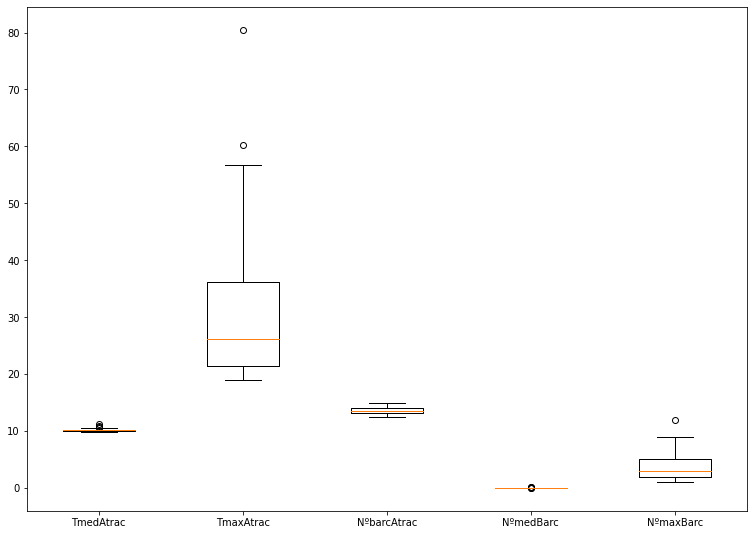

In [26]:
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)

plt.xticks([1, 2, 3, 4, 5], ['TmedAtrac', 'TmaxAtrac', 'NºbarcAtrac',"NºmedBarc","NºmaxBarc"])
# show plot
plt.show()